# Elastic-net regularized Cox proportional hazards with TensorFlow
Author: George H. Chen (georgechen [at symbol] cmu.edu)

This notebook shows how to implement a neural net version of elastic-net regularized Cox proportional hazards using TensorFlow. It uses a survival analysis dataset from the Lifelines library. It also runs standard Cox proportional hazards model fitting without regularization (using Lifelines), and elastic-net regularized Cox proportional hazards (using glmnet) as reference implementations.

Note that the neural net version of elastic-net regularized Cox proportional hazards uses Breslow's method for handling ties (in observed times), meaning that it does not treat ties in any special way (unlike Efron's method, which is used by the Lifelines library).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)

### Load in a simple dataset to try survival regression with

In [2]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()

regression_dataset.head()

regression_dataset_nparray = np.array(regression_dataset)
x = regression_dataset_nparray[:, :3]
y = regression_dataset_nparray[:, 3:]
noncensored = y[:, 1].astype(np.bool)

### Lifelines code for survival regression using Cox proportional hazards (not regularized!)

n=200, number of events=189

       coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95    
var1 0.2214     1.2478    0.0743 2.9807 0.0029      0.0758      0.3669  **
var2 0.0508     1.0521    0.0829 0.6129 0.5400     -0.1117      0.2133    
var3 0.2187     1.2444    0.0758 2.8851 0.0039      0.0701      0.3672  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580
RMSE: 3.42141542709
MAE: 2.6717117037


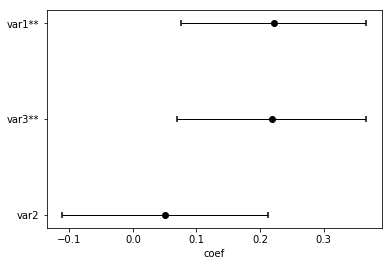

In [3]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(regression_dataset, 'T', event_col='E')
cph.print_summary()
cph.plot()

# it's also possible to extract beta coefficients using the following:
# cph.hazards_.loc['coef'].values

# compute median survival times
cph_median_survival_times = np.array(cph.predict_median(regression_dataset)).flatten()
print('RMSE:',
      np.sqrt(np.mean((cph_median_survival_times[noncensored]
                       - y[noncensored, 0])**2)))
print('MAE:',
      np.mean(np.abs(cph_median_survival_times[noncensored]
                     - y[noncensored, 0])))

### `glmnet` code for elastic-net regularized Cox proportional hazards

In [4]:
import glmnet_python
from glmnet import glmnet
from glmnetCoef import glmnetCoef

lmbda = 0.1
alpha = 1.
fit = glmnet(x=x.copy(), y=y.copy(), family='cox', alpha=alpha, standardize=True, intr=False)
beta = glmnetCoef(fit, s=np.array([lmbda]))
print('Beta:', beta.flatten())

Beta: [ 0.10391  0.       0.09968]


### TensorFlow code for Cox proportional hazards survival layer

In [5]:
# note: to have the code logic more closely resemble what Lifelines' Cox
# proportional hazards model does, we also first standardize the feature vectors
# before fitting (note that Lifelines' Cox proportional hazards model fitter
# undoes the standard deviation scaling right after fitting, but it does *not*
# undo the removal of the mean)

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
x_standardized = standard_scaler.fit_transform(x)

In [6]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

Note that for elastic-net regularization with the Cox proportional hazards model, the standard approach is to use the following regularizer:

$$\lambda \Big(\alpha \|\beta\|_1 + \frac{1}{2}(1-\alpha)\|\beta\|_2^2\Big)$$

In particular, the $\ell_1$ regularization has coefficient $\lambda \alpha$. The $\ell_2$ regularization has coefficient $\lambda (1-\alpha)/2$.

In [7]:
batch_size = len(x)

# warning: depending on the values for lmbda and alpha, a different optimizer
# may be needed to get convergence (inspect training loss over epochs)
lmbda = 0.1  # 0.1
alpha = 1.

l1_weight = lmbda * alpha
l2_weight = lmbda * (1-alpha) / 2.

tf.set_random_seed(1234)

input = tf.placeholder(dtype=tf.float32, shape=[None, x.shape[1]])
labels = tf.placeholder(dtype=tf.float32, shape=[None, 2])

with tf.variable_scope('neural-survival'):
    x_transpose_beta = slim.fully_connected(input, 1, activation_fn=None,
                                            weights_regularizer=slim.l1_l2_regularizer(l1_weight, l2_weight),
                                            biases_initializer=None,
                                            scope='survival')
    
    y_observed_times = labels[:, 0]
    y_event_indicators = labels[:, 1]
    
    R_batch = tf.cast(tf.greater_equal(tf.tile(tf.expand_dims(y_observed_times, axis=0), [batch_size, 1]),
                                       tf.tile(tf.expand_dims(y_observed_times, axis=-1), [1, batch_size])),
                      tf.float32)
    
    tf.losses.add_loss(-tf.reduce_mean(tf.multiply(x_transpose_beta
                                                   - tf.log(tf.matmul(R_batch, tf.exp(x_transpose_beta))),
                                                   tf.expand_dims(y_event_indicators, axis=-1))))
    
    loss = tf.losses.get_total_loss()
    
    train_opt = tf.train.AdamOptimizer().minimize(loss)
    
sess = tf.Session()
all_vars= tf.global_variables()
def get_var(name):
    for i in range(len(all_vars)):
        if all_vars[i].name.startswith(name):
            return all_vars[i]
    return None

sess.run(tf.global_variables_initializer())
for i in range(2000):
    print('Epoch', i + 1, end=' ', flush=True)
    _, loss_val = sess.run([train_opt, loss],
                           feed_dict={input: x_standardized,
                                      labels: y})
    print('-- loss:', loss_val, flush=True)

# just as with Lifelines' Cox proportional hazards model fitter, we undo the
# standard deviation scaling here (but not the mean removal)
coxph_neural_beta = sess.run(get_var('neural-survival/survival/weights')).flatten() / standard_scaler.scale_
print('Beta:', coxph_neural_beta)

Epoch 1 -- loss: 4.4472
Epoch 2 -- loss: 4.44623
Epoch 3 -- loss: 4.44527
Epoch 4 -- loss: 4.4443
Epoch 5 -- loss: 4.44334
Epoch 6 -- loss: 4.44238
Epoch 7 -- loss: 4.44143
Epoch 8 -- loss: 4.44047
Epoch 9 -- loss: 4.43951
Epoch 10 -- loss: 4.43856
Epoch 11 -- loss: 4.4376
Epoch 12 -- loss: 4.43665
Epoch 13 -- loss: 4.43569
Epoch 14 -- loss: 4.43474
Epoch 15 -- loss: 4.43379
Epoch 16 -- loss: 4.43284
Epoch 17 -- loss: 4.43189
Epoch 18 -- loss: 4.43094
Epoch 19 -- loss: 4.42999
Epoch 20 -- loss: 4.42904
Epoch 21 -- loss: 4.4281
Epoch 22 -- loss: 4.42715
Epoch 23 -- loss: 4.42621
Epoch 24 -- loss: 4.42526
Epoch 25 -- loss: 4.42432
Epoch 26 -- loss: 4.42338
Epoch 27 -- loss: 4.42244
Epoch 28 -- loss: 4.4215
Epoch 29 -- loss: 4.42056
Epoch 30 -- loss: 4.41963
Epoch 31 -- loss: 4.41869
Epoch 32 -- loss: 4.41775
Epoch 33 -- loss: 4.41682
Epoch 34 -- loss: 4.41589
Epoch 35 -- loss: 4.41496
Epoch 36 -- loss: 4.41403
Epoch 37 -- loss: 4.4131
Epoch 38 -- loss: 4.41217
Epoch 39 -- loss: 4.41124
E

Epoch 310 -- loss: 4.20279
Epoch 311 -- loss: 4.20218
Epoch 312 -- loss: 4.20158
Epoch 313 -- loss: 4.20097
Epoch 314 -- loss: 4.20037
Epoch 315 -- loss: 4.19977
Epoch 316 -- loss: 4.19917
Epoch 317 -- loss: 4.19857
Epoch 318 -- loss: 4.19797
Epoch 319 -- loss: 4.19737
Epoch 320 -- loss: 4.19678
Epoch 321 -- loss: 4.19619
Epoch 322 -- loss: 4.19559
Epoch 323 -- loss: 4.195
Epoch 324 -- loss: 4.19441
Epoch 325 -- loss: 4.19382
Epoch 326 -- loss: 4.19324
Epoch 327 -- loss: 4.19265
Epoch 328 -- loss: 4.19206
Epoch 329 -- loss: 4.19148
Epoch 330 -- loss: 4.1909
Epoch 331 -- loss: 4.19031
Epoch 332 -- loss: 4.18973
Epoch 333 -- loss: 4.18915
Epoch 334 -- loss: 4.18858
Epoch 335 -- loss: 4.188
Epoch 336 -- loss: 4.18742
Epoch 337 -- loss: 4.18685
Epoch 338 -- loss: 4.18628
Epoch 339 -- loss: 4.1857
Epoch 340 -- loss: 4.18513
Epoch 341 -- loss: 4.18456
Epoch 342 -- loss: 4.18399
Epoch 343 -- loss: 4.18343
Epoch 344 -- loss: 4.18286
Epoch 345 -- loss: 4.1823
Epoch 346 -- loss: 4.18173
Epoch 34

Epoch 615 -- loss: 4.08639
Epoch 616 -- loss: 4.08627
Epoch 617 -- loss: 4.08614
Epoch 618 -- loss: 4.08602
Epoch 619 -- loss: 4.0859
Epoch 620 -- loss: 4.08578
Epoch 621 -- loss: 4.08566
Epoch 622 -- loss: 4.08554
Epoch 623 -- loss: 4.08542
Epoch 624 -- loss: 4.0853
Epoch 625 -- loss: 4.08518
Epoch 626 -- loss: 4.08506
Epoch 627 -- loss: 4.08494
Epoch 628 -- loss: 4.08482
Epoch 629 -- loss: 4.0847
Epoch 630 -- loss: 4.08459
Epoch 631 -- loss: 4.08447
Epoch 632 -- loss: 4.08436
Epoch 633 -- loss: 4.08424
Epoch 634 -- loss: 4.08413
Epoch 635 -- loss: 4.08401
Epoch 636 -- loss: 4.0839
Epoch 637 -- loss: 4.08378
Epoch 638 -- loss: 4.08367
Epoch 639 -- loss: 4.08356
Epoch 640 -- loss: 4.08345
Epoch 641 -- loss: 4.08333
Epoch 642 -- loss: 4.08322
Epoch 643 -- loss: 4.08311
Epoch 644 -- loss: 4.083
Epoch 645 -- loss: 4.08289
Epoch 646 -- loss: 4.08278
Epoch 647 -- loss: 4.08267
Epoch 648 -- loss: 4.08256
Epoch 649 -- loss: 4.08246
Epoch 650 -- loss: 4.08235
Epoch 651 -- loss: 4.08224
Epoch 6

Epoch 920 -- loss: 4.07091
Epoch 921 -- loss: 4.07091
Epoch 922 -- loss: 4.07091
Epoch 923 -- loss: 4.0709
Epoch 924 -- loss: 4.0709
Epoch 925 -- loss: 4.0709
Epoch 926 -- loss: 4.0709
Epoch 927 -- loss: 4.0709
Epoch 928 -- loss: 4.0709
Epoch 929 -- loss: 4.07089
Epoch 930 -- loss: 4.07089
Epoch 931 -- loss: 4.07089
Epoch 932 -- loss: 4.07088
Epoch 933 -- loss: 4.07088
Epoch 934 -- loss: 4.07088
Epoch 935 -- loss: 4.07087
Epoch 936 -- loss: 4.07088
Epoch 937 -- loss: 4.07087
Epoch 938 -- loss: 4.07087
Epoch 939 -- loss: 4.07087
Epoch 940 -- loss: 4.07086
Epoch 941 -- loss: 4.07086
Epoch 942 -- loss: 4.07086
Epoch 943 -- loss: 4.07086
Epoch 944 -- loss: 4.07085
Epoch 945 -- loss: 4.07085
Epoch 946 -- loss: 4.07085
Epoch 947 -- loss: 4.07085
Epoch 948 -- loss: 4.07084
Epoch 949 -- loss: 4.07084
Epoch 950 -- loss: 4.07084
Epoch 951 -- loss: 4.07084
Epoch 952 -- loss: 4.07084
Epoch 953 -- loss: 4.07084
Epoch 954 -- loss: 4.07083
Epoch 955 -- loss: 4.07083
Epoch 956 -- loss: 4.07083
Epoch 9

Epoch 1511 -- loss: 4.07048
Epoch 1512 -- loss: 4.07048
Epoch 1513 -- loss: 4.07049
Epoch 1514 -- loss: 4.07049
Epoch 1515 -- loss: 4.07049
Epoch 1516 -- loss: 4.07048
Epoch 1517 -- loss: 4.07048
Epoch 1518 -- loss: 4.07049
Epoch 1519 -- loss: 4.07049
Epoch 1520 -- loss: 4.07049
Epoch 1521 -- loss: 4.07048
Epoch 1522 -- loss: 4.07048
Epoch 1523 -- loss: 4.07049
Epoch 1524 -- loss: 4.07049
Epoch 1525 -- loss: 4.07049
Epoch 1526 -- loss: 4.07049
Epoch 1527 -- loss: 4.07048
Epoch 1528 -- loss: 4.07048
Epoch 1529 -- loss: 4.07049
Epoch 1530 -- loss: 4.0705
Epoch 1531 -- loss: 4.07049
Epoch 1532 -- loss: 4.07048
Epoch 1533 -- loss: 4.07048
Epoch 1534 -- loss: 4.07049
Epoch 1535 -- loss: 4.07049
Epoch 1536 -- loss: 4.07049
Epoch 1537 -- loss: 4.07048
Epoch 1538 -- loss: 4.07048
Epoch 1539 -- loss: 4.07048
Epoch 1540 -- loss: 4.07049
Epoch 1541 -- loss: 4.07048
Epoch 1542 -- loss: 4.07048
Epoch 1543 -- loss: 4.07048
Epoch 1544 -- loss: 4.07048
Epoch 1545 -- loss: 4.07048
Epoch 1546 -- loss: 4

Epoch 1804 -- loss: 4.07049
Epoch 1805 -- loss: 4.07048
Epoch 1806 -- loss: 4.07047
Epoch 1807 -- loss: 4.07049
Epoch 1808 -- loss: 4.0705
Epoch 1809 -- loss: 4.07049
Epoch 1810 -- loss: 4.07048
Epoch 1811 -- loss: 4.07048
Epoch 1812 -- loss: 4.07048
Epoch 1813 -- loss: 4.07049
Epoch 1814 -- loss: 4.07049
Epoch 1815 -- loss: 4.07048
Epoch 1816 -- loss: 4.07048
Epoch 1817 -- loss: 4.07048
Epoch 1818 -- loss: 4.07048
Epoch 1819 -- loss: 4.07048
Epoch 1820 -- loss: 4.07047
Epoch 1821 -- loss: 4.07048
Epoch 1822 -- loss: 4.07048
Epoch 1823 -- loss: 4.07048
Epoch 1824 -- loss: 4.07047
Epoch 1825 -- loss: 4.07047
Epoch 1826 -- loss: 4.07048
Epoch 1827 -- loss: 4.07048
Epoch 1828 -- loss: 4.07048
Epoch 1829 -- loss: 4.07047
Epoch 1830 -- loss: 4.07047
Epoch 1831 -- loss: 4.07047
Epoch 1832 -- loss: 4.07047
Epoch 1833 -- loss: 4.07047
Epoch 1834 -- loss: 4.07047
Epoch 1835 -- loss: 4.07047
Epoch 1836 -- loss: 4.07047
Epoch 1837 -- loss: 4.07048
Epoch 1838 -- loss: 4.07048
Epoch 1839 -- loss: 4

In [8]:
from collections import Counter
from scipy.special import logsumexp

def predict_median_survival_times(x_test, x_train, y_train, beta,
                                  average_to_get_median=True):
    # note: from inspecting Lifelines' code, Lifelines does not average to get
    # the median (e.g., find 2 nearest median points and take their average);
    # to get numerically nearly identical results, set parameter
    # `average_to_get_median` to False, plug in the beta learned by the
    # Lifelines' Cox proportional hazards, and be sure to subtract off the
    # training feature means from both `x_test` and `x_train`
    observed_times = y_train[:, 0]
    event_indicators = y_train[:, 1]
    
    event_counts = Counter()
    for t, r in zip(observed_times, event_indicators):
        event_counts[t] += int(r)
        
    sorted_unique_times = np.sort(list(event_counts.keys()))
    num_unique_times = len(sorted_unique_times)
    log_baseline_hazard = np.zeros(num_unique_times)
    for time_idx, t in enumerate(sorted_unique_times):
        logsumexp_args = []
        for subj_idx, observed_time in enumerate(observed_times):
            if observed_time >= t:
                logsumexp_args.append(np.inner(beta, x_train[subj_idx]))
        if event_counts[t] > 0:
            log_baseline_hazard[time_idx] \
                = np.log(event_counts[t]) - logsumexp(logsumexp_args)
        else:
            log_baseline_hazard[time_idx] \
                = -np.inf - logsumexp(logsumexp_args)

    # now we work with the test data
    num_test_subjects = len(x_test)
    median_survival_times = np.zeros(num_test_subjects)
    log_minus_log_half = np.log(-np.log(0.5))
    for subj_idx in range(num_test_subjects):
        log_hazard = log_baseline_hazard + np.inner(beta, x_test[subj_idx])
        log_cumulative_hazard = np.zeros(num_unique_times)
        for time_idx in range(num_unique_times):
            log_cumulative_hazard[time_idx] \
                = logsumexp(log_hazard[:time_idx + 1])

        t_inf = np.inf
        t_sup = 0.
        for time_idx, t in enumerate(sorted_unique_times):
            if log_minus_log_half <= log_cumulative_hazard[time_idx]:
                if t < t_inf:
                    t_inf = t
            if log_minus_log_half >= log_cumulative_hazard[time_idx]:
                if t > t_sup:
                    t_sup = t

        if average_to_get_median:
            median_survival_times[subj_idx] = 0.5 * (t_inf + t_sup)
        else:
            median_survival_times[subj_idx] = t_inf

    return median_survival_times

In [9]:
# compute median survival times using the learned neural Cox proportional
# hazards model's beta coefficients; note that at this point, beta already
# undoes the standard deviation scaling but still has mean removal, so to do the
# median survival time prediction, we apply it to the feature vectors with their
# means removed
mean_remover = StandardScaler()
x_zero_mean = mean_remover.fit_transform(x)

coxph_neural_median_survival_times \
    = predict_median_survival_times(x_zero_mean, x_zero_mean,
                                    y, coxph_neural_beta)
import lifelines
print('Concordance:',
      lifelines.utils.concordance_index(y[:, 0],
                                        coxph_neural_median_survival_times,
                                        y[:, 1]))
print('RMSE:',
      np.sqrt(np.mean((coxph_neural_median_survival_times[noncensored]
                       - y[noncensored, 0])**2)))
print('MAE:',
      np.mean(np.abs(coxph_neural_median_survival_times[noncensored]
                     - y[noncensored, 0])))

Concordance: 0.57586538976
RMSE: 3.44293115936
MAE: 2.6907320873
